# Two-Stage Treatment Lasso 
## Group Project: Qihan Guan, Michael Harris, Luyao Wang

In this project, our group was provided with data on whether or not households in India were granted loans based on a variety of provided variables. Our task was to determine how the 'number of connections' variable affected the outcome variable ('loan'), a binary response variable that provided whether or not a loan was granted.

We attempted to assess the impact of the number of connections independent of other X variables. As this was an observational study rather than an experiment, it was necessary to control over all other variables in the multivariate X. 

To do this, our group implemented a two-stage Lasso regression, also called a Treatment Lasso Method. In the first stage, we regressed the number of connections on other X variables to obtain a treatment variable of the number of connections independent of changes in X. In the second stage, we performed a subsequent Lasso regression using our treatment variable, our predicted treatment, and our multivariate X, only penalizing the multivariate X and treatment, and leaving the predicted treatment (d-hat) unpenalized.

To evaluate the effectiveness of our model, we evaluated the Mean Squared Error to measure deviance, and employed a Confusion Matrix to assess our prediction accuracy. 

In [1]:
# library and data
import numpy as np
from numpy import asarray
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from scipy import stats


## Part(1) EDA and transform variables. Create the treatment variable d.

Our treatment variable d is the number of connections that each household has.\
Our dependent variable is the propensity to get a loan, with each household being assigned "0" if no loan was assigned, and "1" if the household received a loan.\
Because this is an observational study and not an experiment, we have to control for other variables that may have an effect on the depdendent variable Y. We thus have to include these variables in the model that we build. 

* Load data and perform EDA

In [2]:
# Load Data into Pandas Dataframe.
households = pd.read_csv("households_data.csv", encoding='latin-1')
households.head()

,loan,hh,village,religion,roof,rooms,beds,electricity,ownership,leader,connections
0,0,1001,1,hindu,tile,3,4,0,OWNED,0,10
1,0,1002,1,hindu,tile,1,1,1,OWNED,1,14
2,0,1003,1,hindu,rcc,3,4,1,OWNED,1,4
3,0,1004,1,hindu,tile,2,6,1,OWNED,0,8
4,0,1005,1,hindu,tile,3,4,1,OWNED,0,16


In [3]:
# Describe dataframe.
households.describe()

,loan,hh,village,rooms,beds,electricity,leader,connections
count,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000
mean,0.145558,41158.936906,41.038854,2.349107,0.867548,0.928671,0.117606,18.633496
std,0.352683,21308.107236,21.306334,1.300611,1.403954,0.257389,0.322160,15.274832
min,0.000000,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25097.250000,25.000000,2.000000,0.000000,1.000000,0.000000,6.000000
50%,0.000000,43029.500000,43.000000,2.000000,0.000000,1.000000,0.000000,16.000000
75%,0.000000,59078.750000,59.000000,3.000000,1.000000,1.000000,0.000000,28.000000
max,1.000000,75172.000000,75.000000,19.000000,50.000000,1.000000,1.000000,180.000000


In [4]:
# Check for null values:
# No null values, no need to replace.
households.isnull().values.any()

False

In [5]:
# Get data dimensions - 11 columns and 8,622 cases.
print(households.shape)

(8622, 11)


In [6]:
# Print Data types.
print(households.dtypes)

loan            int64
hh              int64
village         int64
religion       object
roof           object
rooms           int64
beds            int64
electricity     int64
ownership      object
leader          int64
connections     int64
dtype: object


* Count Frequencies of categorical values

In [ ]:
# Count Frequencies of categorical values in village column.
households['village'].value_counts()

59    329
52    327
28    315
71    298
65    297
3     292
29    290
36    289
39    287
46    261
55    257
23    254
25    252
51    251
50    244
32    241
4     237
72    223
45    221
57    208
70    205
19    204
33    204
21    202
43    198
2     195
67    193
42    192
62    190
1     182
12    175
73    174
75    172
24    163
20    155
68    153
31    153
47    139
Name: village, dtype: int64

In [ ]:
# Count Frequencies of categorical values in religion column.
households['religion'].value_counts()


hindu        8185
islam         430
christian       7
Name: religion, dtype: int64

In [ ]:
# Count Frequencies of categorical values in roof column.
households['roof'].value_counts()


tile      2925
stone     2487
sheet     1659
rcc        941
other      420
thatch     190
Name: roof, dtype: int64

In [ ]:
# Count Frequencies of categorical values in electricity column.
households['electricity'].value_counts()

1    8007
0     615
Name: electricity, dtype: int64

In [ ]:
# Count Frequencies of categorical values in ownership column.
households['ownership'].value_counts()

OWNED          7834
RENTED          434
GOVERNMENT      263
SHARE_OWNED      76
LEASED           15
Name: ownership, dtype: int64

In [ ]:
# Count Frequencies of categorical values in leader column.
households['leader'].value_counts()

0    7608
1    1014
Name: leader, dtype: int64

In [5]:
# 'hh' is just the id column, we will drop it
households = households.drop(['hh'], axis=1)

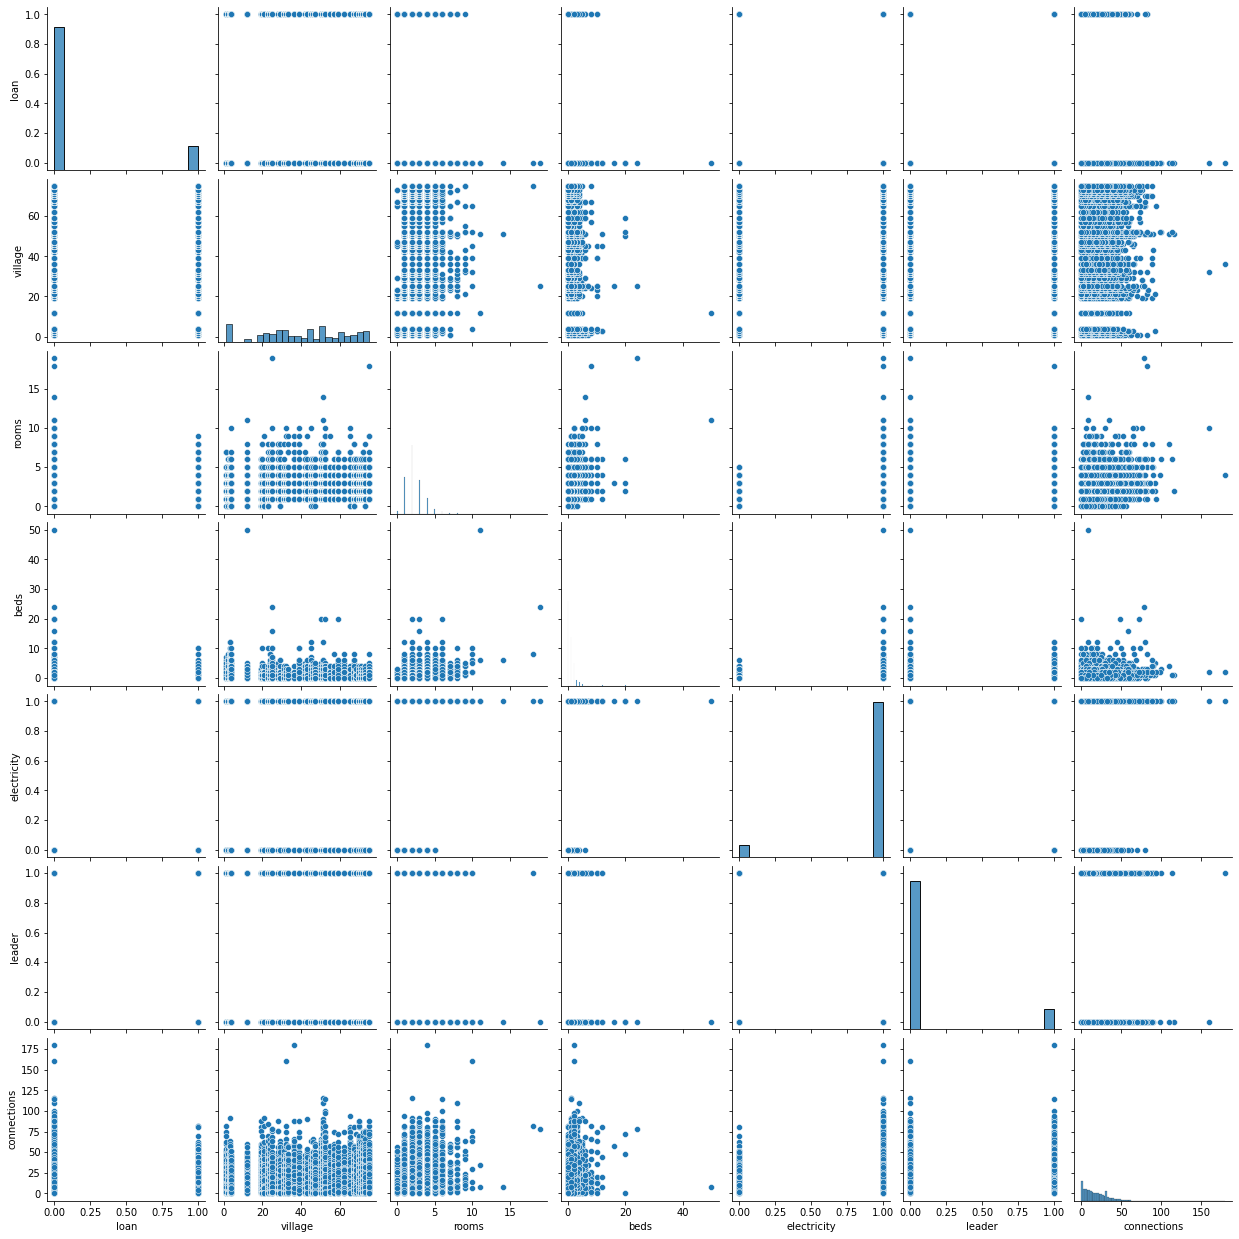

In [ ]:
#Create pair plot to look at the relationship 
sns.pairplot(households, diag_kind="hist")

By looking at the pairplot alone, we can observe some confounding effects. We will need to remove the counfounding effect for treatment d in the later parts.

* Create dummy variables for categorical variables village, religion, roof, and ownership. No need for one-hot encoding for loan, electricity and leader since they are all valued as 0 or 1. 

In [6]:
# Create dummies variable 
households1 = pd.get_dummies(households, columns=['village','religion','roof','ownership']) 
households1

,loan,rooms,beds,electricity,leader,connections,village_1,village_2,village_3,village_4,...,roof_rcc,roof_sheet,roof_stone,roof_thatch,roof_tile,ownership_GOVERNMENT,ownership_LEASED,ownership_OWNED,ownership_RENTED,ownership_SHARE_OWNED
0,0,3,4,0,0,10,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,1,1,1,1,14,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,3,4,1,1,4,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,2,6,1,0,8,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,3,4,1,0,16,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8617,0,3,0,1,0,32,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8618,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
8619,0,2,0,1,0,6,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8620,0,2,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


* From the hist plot, we observed that the quantitative variables connections, rooms, and beds are skewed. In addition, the variables have large difference in magnitude. Since we will perform lasso regression later, which will use regularization, we need to scale the data first.  

In [7]:
scaler = StandardScaler()
households2 = households1.copy()
households2[['rooms','beds','connections']] = scaler.fit_transform(households2[['rooms','beds','connections']])
households2

,loan,rooms,beds,electricity,leader,connections,village_1,village_2,village_3,village_4,...,roof_rcc,roof_sheet,roof_stone,roof_thatch,roof_tile,ownership_GOVERNMENT,ownership_LEASED,ownership_OWNED,ownership_RENTED,ownership_SHARE_OWNED
0,0,0.500481,2.231294,0,0,-0.565243,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,-1.037347,0.094347,1,1,-0.303359,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0.500481,2.231294,1,1,-0.958069,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,-0.268433,3.655924,1,0,-0.696185,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,0.500481,2.231294,1,0,-0.172418,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8617,0,0.500481,-0.617968,1,0,0.875118,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8618,0,-1.037347,-0.617968,0,0,-1.089011,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
8619,0,-0.268433,-0.617968,1,0,-0.827127,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8620,0,-0.268433,-0.617968,1,1,-1.219953,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


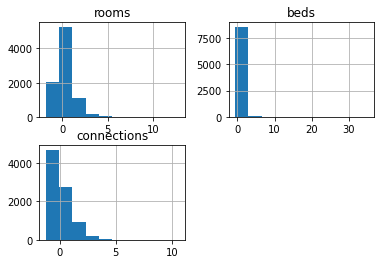

In [7]:
households2.copy().hist(['rooms','beds','connections']);

The skewness is mitigated. 

In [8]:
# Isolate quantitative varibles.
data_quant = households2[['rooms','beds','connections']]
#Create correlation matrix 
data_quant.corr()

,rooms,beds,connections
rooms,1.000000,0.420386,0.194857
beds,0.420386,1.000000,0.113672
connections,0.194857,0.113672,1.000000


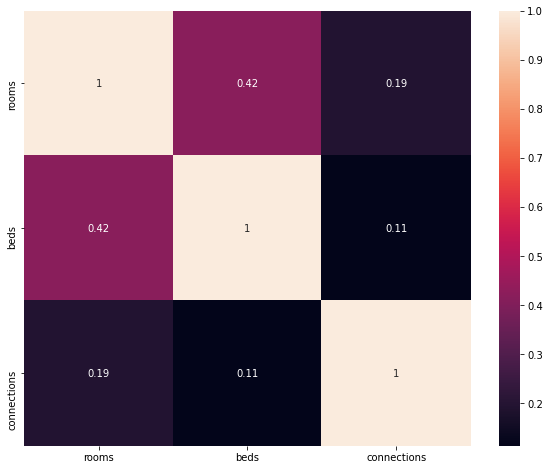

In [9]:
# Correlation matrix.
plt.subplots(figsize=(10, 8))
sns.heatmap(data_quant.corr().abs(),annot=True)
plt.show()

Beds and rooms are correlated as expected. Rooms and beds also have some correlation with the treatment 'connections.' Again, we will need to remove the confounding effects later.  

* Our treatment variable d

In [8]:
# Treatment variable d
d = households2['connections']
d

0      -0.565243
1      -0.303359
2      -0.958069
3      -0.696185
4      -0.172418
          ...   
8617    0.875118
8618   -1.089011
8619   -0.827127
8620   -1.219953
8621   -0.696185
Name: connections, Length: 8622, dtype: float64

## Part(2) Model Building

**For this part the will run d ~ X with interactions up to degree of 3.**

In [9]:
# Get control variables 
X = households2.copy().drop(['loan', 'connections'], axis = 1)

# No need to add degree to dummy variables. Only add degree 2 and 3 to 'rooms', and 'beds'
X['rooms^2'] = np.power(X['rooms'],2)
X['rooms^3'] = np.power(X['rooms'],3)
X['beds^2'] = np.power(X['beds'],2)
X['beds^3'] = np.power(X['beds'],3)

# Create all combinations of interactions using PloynomialFeatures()
poly = preprocessing.PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# We generated 1830 interaction terms
len(poly.get_feature_names(X.columns))
poly.get_feature_names(X.columns)

['rooms',
 'beds',
 'electricity',
 'leader',
 'village_1',
 'village_2',
 'village_3',
 'village_4',
 'village_12',
 'village_19',
 'village_20',
 'village_21',
 'village_23',
 'village_24',
 'village_25',
 'village_28',
 'village_29',
 'village_31',
 'village_32',
 'village_33',
 'village_36',
 'village_39',
 'village_42',
 'village_43',
 'village_45',
 'village_46',
 'village_47',
 'village_50',
 'village_51',
 'village_52',
 'village_55',
 'village_57',
 'village_59',
 'village_62',
 'village_65',
 'village_67',
 'village_68',
 'village_70',
 'village_71',
 'village_72',
 'village_73',
 'village_75',
 'religion_christian',
 'religion_hindu',
 'religion_islam',
 'roof_other',
 'roof_rcc',
 'roof_sheet',
 'roof_stone',
 'roof_thatch',
 'roof_tile',
 'ownership_GOVERNMENT',
 'ownership_LEASED',
 'ownership_OWNED',
 'ownership_RENTED',
 'ownership_SHARE_OWNED',
 'rooms^2',
 'rooms^3',
 'beds^2',
 'beds^3',
 'rooms beds',
 'rooms electricity',
 'rooms leader',
 'rooms village_1',
 'room

In [10]:
# Before running lasso + CV, we can first fit an OLS and exclude some interactions based on the p-value. 
# Let the p-value cut-off be 0.01.

# Statsmodels.OLS requires to add a constant.
x = sm.add_constant(X_poly)
ols_model = sm.OLS(d,x)
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            connections   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     2.847
Date:                Tue, 16 Feb 2021   Prob (F-statistic):          2.43e-112
Time:                        20:41:23   Log-Likelihood:                -11186.
No. Observations:                8622   AIC:                         2.389e+04
Df Residuals:                    7861   BIC:                         2.927e+04
Df Model:                         760                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1146      0.129     -0.888      0.3

In [11]:
# note X_poly is a np.array data type(multi-dimensional)
# Let the p-value cut-off be 0.01. Drop the interaction term if its p-value is above the threshold.

# initialize a list of indices for dropping the interaction terms in X_poly
index_todrop = []
for i in range (1, 1831): # exclude intercept
   if results.pvalues[i] > 0.01 or np.isnan(results.pvalues[i]):
     index_todrop.append(i-1)

# drop the insignificant interaction terms
X_poly_cut = np.delete(arr = X_poly, obj = index_todrop, axis = 1) 

# check how many interaction terms retained
X_poly_cut.shape[1] #28 interaction terms retained, model complexity greatly reduced.

28

In [12]:
# Check what interaction terms are retained
interactions = poly.get_feature_names(X.columns)
retained_interactions = np.delete(interactions, index_todrop)

In [13]:
# Print to screen the retained interaction terms
print(retained_interactions)

['leader' 'village_33' 'rooms leader' 'rooms roof_tile' 'beds village_1'
 'beds village_36' 'electricity village_70' 'electricity village_71'
 'leader village_1' 'leader village_71' 'leader ownership_SHARE_OWNED'
 'village_2 village_19' 'village_19 village_24' 'village_21 village_75'
 'village_23 village_73' 'village_23 religion_christian'
 'village_33 religion_hindu' 'village_36 ownership_SHARE_OWNED'
 'village_36 beds^2' 'village_36 beds^3' 'village_50 roof_rcc'
 'village_52 rooms^2' 'village_52 rooms^3' 'village_59 ownership_LEASED'
 'religion_islam ownership_GOVERNMENT' 'roof_sheet ownership_OWNED'
 'roof_sheet ownership_RENTED' 'roof_sheet ownership_SHARE_OWNED']


In [16]:
# Run the OLS again with the selected interactions
x = sm.add_constant(X_poly_cut)
ols_model = sm.OLS(d,x)
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            connections   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     28.35
Date:                Wed, 17 Feb 2021   Prob (F-statistic):          2.30e-113
Time:                        04:32:54   Log-Likelihood:                -11932.
No. Observations:                8622   AIC:                         2.391e+04
Df Residuals:                    8599   BIC:                         2.407e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0707      0.013     -5.585      0.0

BIC got lower after dropping the insignificant interaction terms.

**Now run lasso + CV for model selection on d ~ X_poly_cut**

In [14]:
from sklearn.linear_model import LassoCV

#candidate of lambdas
lambdas = np.logspace(-10, 1, 100)

#cross validation 10-folds
cv_lasso = LassoCV(alphas=lambdas, cv=10)
cv_lasso.fit(X_poly_cut, d)

#print the best regularization parameter lambda
print(cv_lasso.alpha_)


0.002154434690031882


In [15]:
# Get the in-sample R-squared value
cv_lasso.score(X_poly_cut, d)

0.05621921371990035

The R-squared value given by lasso tells us that around 6% of the variation in treatment d is explained by the control variables. The left out part is the independent/causal effect of d that we need to study. 

In [16]:
# Get the d_hat
d_hat = cv_lasso.predict(X_poly_cut) 

## Part (3) Prediction

In [17]:
# Convert d to numpy array to combine with d_hat and X_Poly_cut to be ran in future lasso. 

d = d.copy().to_numpy(d)
print(d.shape)
print(d_hat.shape)


(8622,)
(8622,)


lambda = 1e-05

Printing the coefficient for treatment d:

0.006691846082907978

MSE: 0.12322035716501356

confusion matrix:

[[5523 1844]
 [ 835  420]]

accuracy score:
0.6892832289491997

-----------------------------------------------------------------

lambda = 0.0001

Printing the coefficient for treatment d:

0.006642302661005687

MSE: 0.12330483868964219

confusion matrix:

[[6034 1333]
 [ 936  319]]

accuracy score:
0.736836000927859

-----------------------------------------------------------------

lambda = 0.001

Printing the coefficient for treatment d:

0.006804852900224198

MSE: 0.12523321129338397

confusion matrix:

[[6559  808]
 [1061  194]]

accuracy score:
0.7832289491997216

-----------------------------------------------------------------

lambda = 0.01

Printing the coefficient for treatment d:

0.0

MSE: 0.14555787520296914

confusion matrix:

[[7367    0]
 [1255    0]]

accuracy score:
0.8544421247970309

---------------------------------------------------------

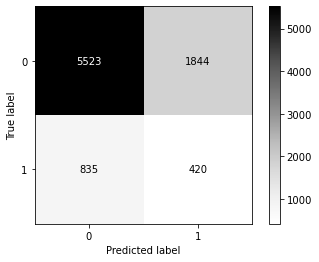

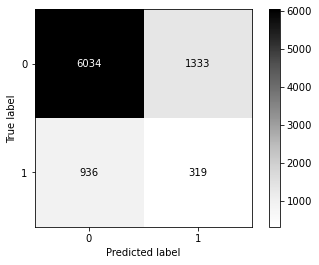

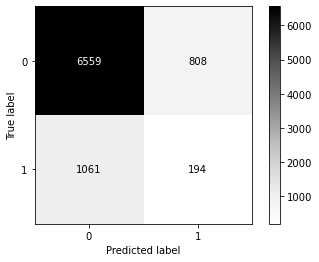

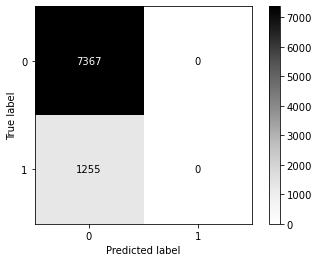

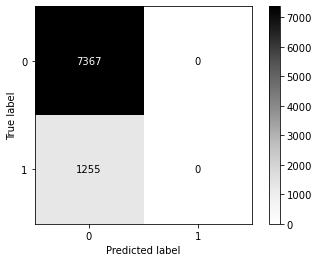

In [25]:
# Combine d, d_hat, and other control variables with selected interaction terms
A = np.column_stack((d, d_hat, X_poly_cut))

# Get the dependent variable 'loan'
y = households2['loan']

# Regluarization parameter
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1] 

# Set weights
weights=np.ones(A.shape[1])

for alpha in lambdas:
  # Run lasso + CV for loan ~ d + d_hat + X_poly_cut （no intercept）
  """ scipy """
  from scipy.optimize import minimize
  def lasso(x):  # following sklearn's definition from user-guide!
      return (1. / (2*A.shape[0])) * np.square(np.linalg.norm(A.dot(x) - y, 2)) + alpha * np.linalg.norm(weights*x, 1)

  """ Test scipy-based with special weights """
  weights[[0, 1]] = 0.0
  x0 = np.zeros(A.shape[1])
  res = minimize(lasso, x0, method='L-BFGS-B', options={'disp': False}) 

  # print the coefficients to screen 
  print('lambda = ' + str(alpha) + '\n')
  print('Printing the coefficient for treatment d:\n')
  print(res.x[0])
  # use the above coefficients to calculate predicted 'loan'
  y_hat = A.dot(res.x)
  y_hat = pd.Series(y_hat)
  # calcualte the raw MSE score for part 3's model
  MSE3 = np.square(np.subtract(y, y_hat)).mean() 
  print('\nMSE: ' + str(MSE3) +'\n')

  # suggest a cutoff for predicted loan and transform it to 0 or 1
  y_hat_binary = np.zeros(len(y_hat))
  for i in range(0, len(y_hat)):
    y_hat_binary[i] = 1 if y_hat[i] > 0.15 else 0 # set cutoff to 0.15 because we have way more 0 than 1's in the observations

  # Confusion Matrix
  from sklearn.metrics import confusion_matrix
  print('confusion matrix:\n')
  print(confusion_matrix(y, y_hat_binary))
  # Accuracy
  from sklearn.metrics import accuracy_score
  print('\naccuracy score:')
  print(accuracy_score(y, y_hat_binary))
  # Plot confusion matrix
  diagram = metrics.ConfusionMatrixDisplay(confusion_matrix(y, y_hat_binary),display_labels=None)
  diagram.plot(cmap = 'Greys')
  print('\n-----------------------------------------------------------------\n')

## Part (4) Model Comparison

**Fit naive lasso**

In [21]:
# Naive lasso would be taking all the indepndent variables at once rather than running a preliminary lasso to regress 
# connections on other independent variables.
# Notice that we don't include d_hat, just the connections variable and interaction terms obtained in part 2.

X_4 = np.column_stack((d, X_poly_cut))
print(X_4)

[[-0.56524332  0.          0.         ...  0.          0.
   0.        ]
 [-0.30335945  1.          0.         ...  0.          0.
   0.        ]
 [-0.95806912  1.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.82712718  0.          0.         ...  0.          0.
   0.        ]
 [-1.21995299  1.          0.         ...  0.          0.
   0.        ]
 [-0.69618525  0.          0.         ...  0.          0.
   0.        ]]


lambda = 1e-05

Printing the coefficient for treatment d:

0.006672616951967303


MSE: 0.1232204181034162

confusion matrix:
[[5496 1871]
 [ 825  430]]

accuracy score:
0.6873115286476456

-----------------------------------------------------------------

lambda = 0.0001

Printing the coefficient for treatment d:

0.006291072076424723


MSE: 0.12328412006923094

confusion matrix:
[[5587 1780]
 [ 852  403]]

accuracy score:
0.6947344003711435

-----------------------------------------------------------------

lambda = 0.001

Printing the coefficient for treatment d:

0.004801325094655556


MSE: 0.12367576388635597

confusion matrix:
[[6281 1086]
 [1004  251]]

accuracy score:
0.7575968452795175

-----------------------------------------------------------------

lambda = 0.01

Printing the coefficient for treatment d:

0.0


MSE: 0.12435879944913045

confusion matrix:
[[7367    0]
 [1255    0]]

accuracy score:
0.8544421247970309

---------------------------------------------------------

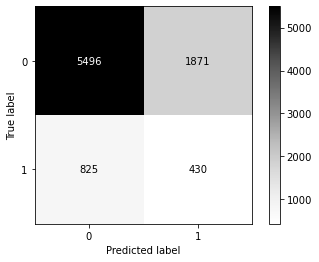

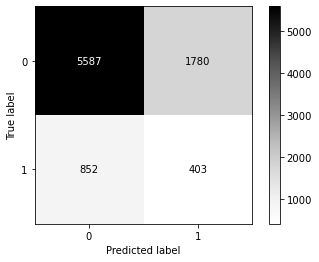

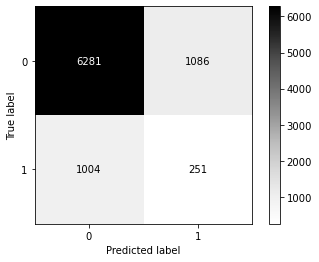

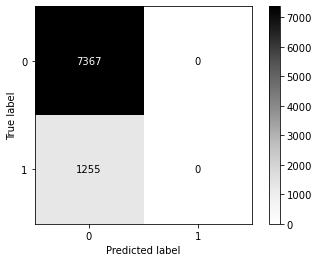

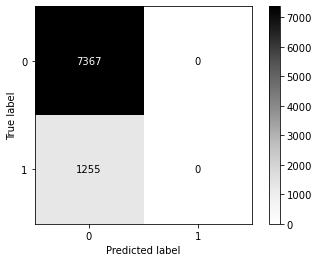

In [26]:
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1] 

for i in lambdas:
    lasso_naive = Lasso(alpha=i).fit(X_4,y)
    y_hat_naive = lasso_naive.predict(X_4)
    
    #Print the lambda
    print('lambda = ' + str(i) + '\n')
    print('Printing the coefficient for treatment d:\n')
    print(lasso_naive.coef_[0])
    
    # MSE for naive lasso
    MSE4 = np.square(np.subtract(y, y_hat_naive)).mean() 
    print('\n\nMSE: ' + str(MSE4))

    # suggest a cutoff for predicted loan and transform it to 0 or 1
    y_hat_naive_binary = np.zeros(len(y_hat_naive))
    for i in range(0, len(y_hat_naive)):
          y_hat_naive_binary[i] = 1 if y_hat_naive[i] > 0.15 else 0
            
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix
    print('\nconfusion matrix:')
    print(confusion_matrix(y, y_hat_naive_binary))
    # Accuracy
    from sklearn.metrics import accuracy_score
    print('\naccuracy score:')
    print(accuracy_score(y, y_hat_naive_binary))
    # Plot confusion matrix
    diagram = metrics.ConfusionMatrixDisplay(confusion_matrix(y, y_hat_naive_binary),display_labels=None)
    diagram.plot(cmap = 'Greys')
    print('\n-----------------------------------------------------------------\n')